# **Sprint 9 Showz analysis**

## Paso 1. Acceda los datos y prepáralos para el análisis

Almacena los datos de visitas, pedidos y gastos en variables.  Optimiza los datos para el análisis. Asegúrate de que cada columna contenga el tipo de datos correcto. 




In [ ]:
# cargar librerías
import pandas as pd 
import numpy as np
import re 
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# importar datos
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_log_us.csv')
print(visits.head())
print('-------')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_log_us.csv')
print(orders.head())
print('-------')
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_us.csv')
print(costs.head())
print('-------')

### Examinar visits

In [ ]:
# Examine visits
visits.info()

In [ ]:
visits['Device'].value_counts()

In [ ]:
visits['Source Id'].value_counts()

### Limpiar visits
1. Columnas a minúsculas
2. End Ts y Start Ts a formato fecha

In [ ]:
# Función para limpiar columnas
def clean_col_names(df):
    df = df.copy()
    df.columns = [
        re.sub(r'\W+', '_', col).strip('_').lower()
        for col in df.columns
    ]
    return df


In [ ]:
# Limpiar visits.columns
visits = clean_col_names(visits)
visits

In [ ]:
# Cambiar end_ts y start_ts a formato fecha
visits.end_ts = pd.to_datetime(visits['end_ts'])
visits.start_ts = pd.to_datetime(visits['start_ts'])
print(visits.info())

In [ ]:
visits.sample(10)

### Examinar orders

In [ ]:
# Examine orders
orders.info()

In [ ]:
orders['Revenue'].describe()

In [ ]:
orders[orders.Revenue > 1000]

### Limpiar orders

1. limpiar nombres de columnas
2. 'Buy Ts' a formato fecha

In [ ]:
orders = clean_col_names(orders)
orders.buy_ts = pd.to_datetime(orders.buy_ts)
orders.info()

### Examinar costs

In [ ]:
# Examine costs
costs.info()

In [ ]:
costs.sample(5)

In [ ]:
costs.source_id.value_counts()

### Limpiar costs

1. 'dt' a formato fecha

In [ ]:
costs.dt = pd.to_datetime(costs.dt)
costs.info()

## Paso 2. Haz informes y calcula métricas 

### Visitas:
- ¿Cuántas personas lo usan cada día, semana y mes?
- ¿Cuántas sesiones hay por día? (Un usuario puede tener más de una sesión).
- ¿Cuál es la duración de cada sesión?
- ¿Con qué frecuencia los usuarios regresan?






In [ ]:
# Primero sacaremos de las fechas, el día, la semana, mes y año de la visita
visits['day'] = visits['start_ts'].dt.weekday
visits['week'] = visits['start_ts'].dt.isocalendar().week
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.isocalendar().year
visits.sample(10)

In [ ]:
#Promedio de visitas por día

by_days = visits.groupby(['week', 'day'])['uid'].nunique().reset_index()
print(f'Al día, en promedio, se tienen {by_days.uid.mean():,.2f} visitas.')


In [ ]:
#Promedio de visitas por semana

by_week = visits.groupby(['year', 'week'])['uid'].nunique().reset_index()
print(f'Por semana, en promedio, tenemos {by_week.uid.mean():,.2f} visitas')

In [ ]:
#Promedio de visitas por semana

by_month = visits.groupby(['year', 'month'])['uid'].nunique().reset_index()
print(f'Por mes, en promedio, tenemos {by_month.uid.mean():,.2f} visitas')

In [ ]:
#Promedio de sesiones por día

sessions_per_day = visits.groupby(['week', 'day'])['uid'].count().reset_index()
print(f'Al día, en promedio, se tienen {sessions_per_day.uid.mean():,.2f} sesiones.')

In [ ]:
# Duración de sesiones

visits['session_duration'] = visits.end_ts - visits.start_ts
visits['session_duration_secs'] = visits.session_duration.dt.total_seconds()
avg_session_duration = visits.session_duration_secs.median()
print(f'La media de la duración de la sesión es de {avg_session_duration/60:,.2f} minutos.')

In [24]:
# Con qué frecuencia los usuarios regresan? 
comeback_frec = visits.sort_values(by=['uid', 'start_ts'])
visits['time_since_last_visit'] = comeback_frec.groupby(['uid'])['start_ts'].diff()
visits['days_between_visits'] = visits.time_since_last_visit.dt.days
ave_return_time = visits.days_between_visits.median()
print(f'La media del tiempo en que suelen regresar los usuarios es de {ave_return_time:.2f} días.')


La media del tiempo en que suelen regresar los usuarios es de 4.00 días.


En la duración de la sesión y en el tiempo en que suelen regresar los usuarios usamos **la media**, ya que en el promedio los valores atípicos elevaban las cantidades.

### Ventas:
- ¿Cuándo empieza la gente a comprar? (En el análisis de KPI, generalmente nos interesa saber el tiempo que transcurre entre el registro y la conversión, es decir, cuando el usuario se convierte en cliente. Por ejemplo, si el registro y la primera compra ocurren el mismo día, el usuario podría caer en la categoría Conversion 0d. Si la primera compra ocurre al día siguiente, será Conversion 1d. Puedes usar cualquier enfoque que te permita comparar las conversiones de diferentes cohortes para que puedas determinar qué cohorte o canal de marketing es más efectivo.)
- ¿Cuántos pedidos hacen durante un período de tiempo dado?
- ¿Cuál es el tamaño promedio de compra?
- ¿Cuánto dinero traen? (LTV)

In [25]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [26]:
# Fechas de primeras compras
purchases = orders[orders.revenue > 0]
first_purchase = purchases.groupby('uid')['buy_ts'].min().reset_index()
first_purchase.columns = ['uid', 'first_buy_ts']
orders = pd.merge(orders, first_purchase, on='uid')
#orders.sample(5)



In [27]:
# Fechas de registros
registration = orders.groupby('uid')['buy_ts'].min().reset_index()
registration.columns = ['uid', 'registration_ts']
orders = pd.merge(orders, registration, on='uid')
#orders.sample(5)

In [28]:
# Crear cohortes por días transcurridos para comprar despúes del registro
orders['days_to_purchase'] = (orders['first_buy_ts'] - orders['registration_ts']).dt.days
#orders.sample(5)

In [29]:
orders['convertion_delay'] = orders['days_to_purchase'].apply(lambda x: f'{x}d')
#orders.sample(5)

In [30]:
by_cohorts = orders.groupby('convertion_delay')['uid'].nunique()
by_cohorts

convertion_delay
0d      36504
117d        1
12d         1
167d        1
3d          1
65d         1
Name: uid, dtype: int64

Practicamente el 99% de los usuarios compran el mismo día que se registraron. 

Probablemente no sabían de la aplicación, ni les interesaba registrarse hasta que quisieron comprar boletos para un evento al que sí querían asistir.

Como este dato no nos sirve para crear cohortes relevante, agruparemos por dispositivo de usuario

In [31]:
#vamos a agrupar por devices, vamos a ver si hay más de un device por usuario

devices_per_user = visits.groupby('uid')['device'].nunique()
devices_per_user.value_counts()

1    220470
2      7699
Name: device, dtype: int64

In [32]:
devices_per_user = visits.groupby('uid')['device'].nunique()
devices_per_user.value_counts()

1    220470
2      7699
Name: device, dtype: int64

In [33]:
# añadiremos el source_id a nuestro df donde identificamos los cohortes
by_source = visits.groupby('uid')['source_id'].nunique()
orders = orders.merge(by_source, on='uid')

In [34]:
by_cohorts_source = orders.groupby('source_id')['uid'].nunique()
by_cohorts_source

source_id
1    22431
2     9346
3     3268
4     1079
5      321
6       55
7        9
Name: uid, dtype: int64

In [35]:
source_conversion = (
    orders.groupby('source_id')
    .agg({'uid':'nunique', 'revenue':'sum'})
    .rename(columns={'uid':'unique_users'})
    .sort_values(by='unique_users',ascending=False)
)

source_conversion

,unique_users,revenue
source_id,,
1,22431,98724.56
2,9346,66168.56
3,3268,30065.66
4,1079,18180.00
5,321,35459.94
6,55,2676.61
7,9,781.87


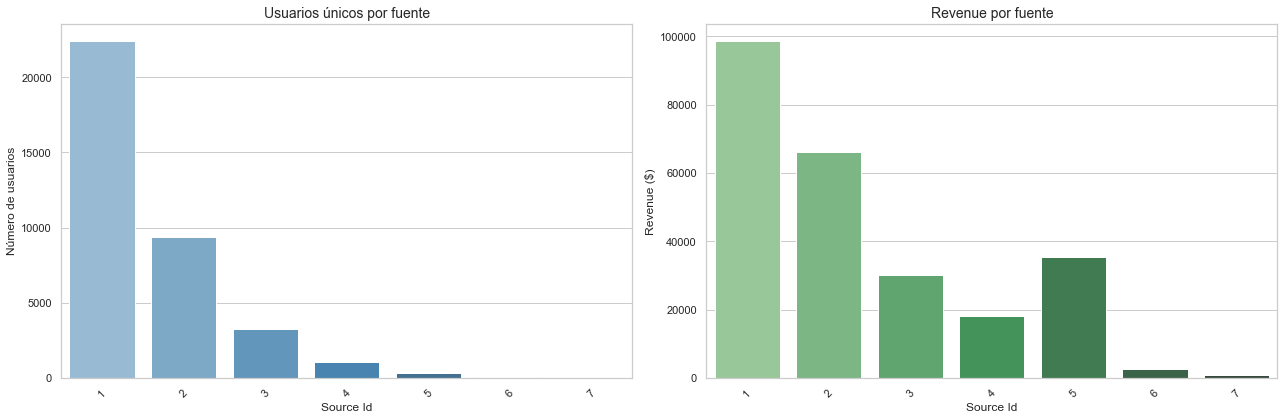

In [36]:
# Crear el canvas de Usuarios únicos y el Revenue por Source Id
sns.set(style="whitegrid")

# Crear figura y subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Primer gráfico: Usuarios únicos
sns.barplot(
    x=source_conversion.index,
    y=source_conversion['unique_users'],
    palette='Blues_d',
    ax=axes[0]
)
axes[0].set_title('Usuarios únicos por fuente', fontsize=14)
axes[0].set_xlabel('Source Id')
axes[0].set_ylabel('Número de usuarios')
axes[0].tick_params(axis='x', rotation=45)

# Segundo gráfico: Revenue
sns.barplot(
    x=source_conversion.index,
    y=source_conversion['revenue'],
    palette='Greens_d',
    ax=axes[1]
)
axes[1].set_title('Revenue por fuente', fontsize=14)
axes[1].set_xlabel('Source Id')
axes[1].set_ylabel('Revenue ($)')
axes[1].tick_params(axis='x', rotation=45)

# Ajustar espacio
plt.tight_layout()
plt.show()


In [37]:
source_conversion['revenue_per_user'] = (source_conversion.revenue / source_conversion.unique_users)
source_conversion

,unique_users,revenue,revenue_per_user
source_id,,,
1,22431,98724.56,4.401255
2,9346,66168.56,7.079880
3,3268,30065.66,9.200018
4,1079,18180.00,16.848934
5,321,35459.94,110.467103
6,55,2676.61,48.665636
7,9,781.87,86.874444


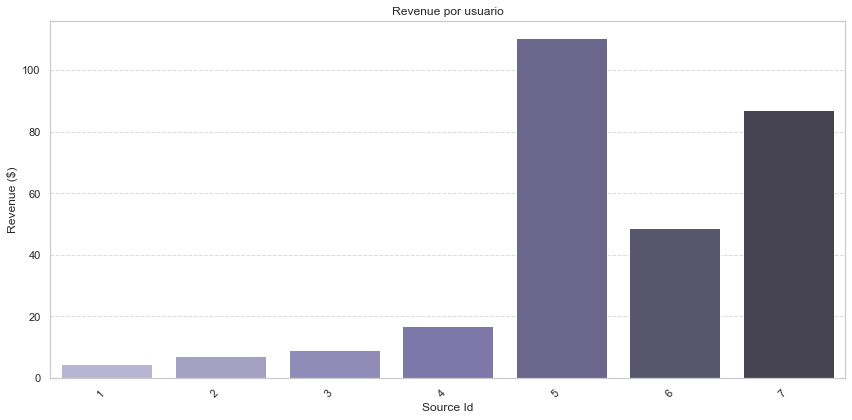

In [38]:
sns.set(style="whitegrid")

plt.figure(figsize=(12,6))

sns.barplot(
    x=source_conversion.index,
    y=source_conversion['revenue_per_user'],
    palette='Purples_d'
)

plt.xticks(rotation=45, ha='right')
plt.title('Revenue por usuario')
plt.xlabel('Source Id')
plt.ylabel('Revenue ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Los canales de Mkt que más usuarios únicos atraparon también fueron los canales que más revenue generaron. Sin embargo el source Id 5 llama la atención porque aunque había pocos usuarios únicos, sus resultados de revenue fueron mucho mayores. Al llevar a cabo la gráfica descubrimos que de hecho los últimos source id's son los que más ingresos generaron por usuario. 

**La recomendación es invertir más en esos sources id's, 5, 6 y 7, para atraer más de esos usuarios que son los que más están dispuestos a gastar en la aplicación.**

In [39]:
# Cuántos pedidos se hacen en un periodo de compra? 
orders['month_buy'] = orders.buy_ts.dt.month
orders['year_buy'] = orders.buy_ts.dt.year
orders.sample(10)

,buy_ts,revenue,uid,first_buy_ts,registration_ts,days_to_purchase,convertion_delay,source_id,month_buy,year_buy
10903,2017-09-13 15:08:00,3.67,2148167223562433737,2017-09-13 15:08:00,2017-09-13 15:08:00,0,0d,2,9,2017
8696,2017-08-24 15:40:00,4.89,9021816583202097861,2017-08-24 15:40:00,2017-08-24 15:40:00,0,0d,2,8,2017
32016,2018-02-07 12:10:00,1.16,9769372827553885872,2018-01-06 13:36:00,2018-01-06 13:36:00,0,0d,3,2,2018
31602,2018-01-03 12:59:00,0.67,8390280518447277243,2018-01-03 12:59:00,2018-01-03 12:59:00,0,0d,1,1,2018
9491,2017-08-31 22:17:00,14.67,7850171525612042447,2017-08-31 15:26:00,2017-08-31 15:26:00,0,0d,2,8,2017
6967,2017-10-08 13:28:00,22.22,3601099419845979773,2017-07-26 08:17:00,2017-07-26 08:17:00,0,0d,3,10,2017
2677,2017-06-09 12:58:00,2.08,17719152684044931457,2017-06-09 12:58:00,2017-06-09 12:58:00,0,0d,3,6,2017
486,2017-06-06 10:38:00,3.05,1210481103526146221,2017-06-02 10:18:00,2017-06-02 10:18:00,0,0d,2,6,2017
13487,2017-10-01 16:23:00,1.40,5466797489048083406,2017-10-01 16:23:00,2017-10-01 16:23:00,0,0d,1,10,2017
34011,2018-03-04 12:01:00,0.73,10765652490730753803,2018-01-22 22:38:00,2018-01-22 22:38:00,0,0d,2,3,2018


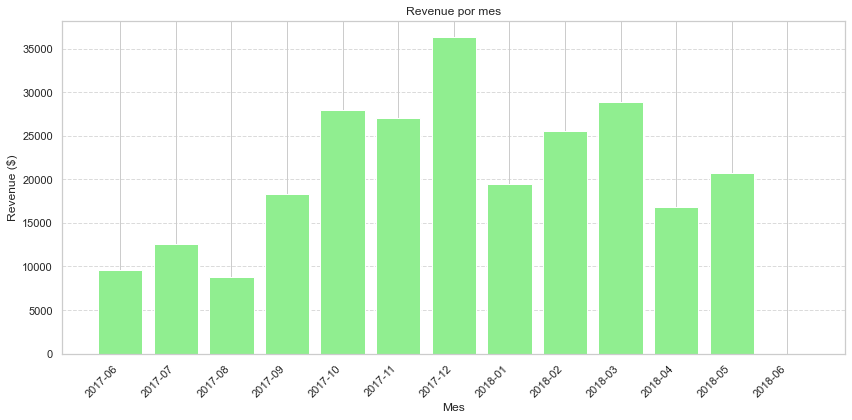

In [48]:
revenue_by_month = orders.groupby(['year_buy', 'month_buy'])['revenue'].sum().reset_index()

# Crear una columna tipo fecha con año y mes (como string)
revenue_by_month['period'] = revenue_by_month['year_buy'].astype(str) + '-' + revenue_by_month['month_buy'].astype(str).str.zfill(2)


plt.figure(figsize=(12,6))
plt.bar(revenue_by_month.period, revenue_by_month['revenue'], color='lightgreen')
plt.xticks(rotation=45, ha='right')
plt.title('Revenue por mes')
plt.xlabel('Mes')
plt.ylabel('Revenue ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Marketing:
 1. ¿Cuánto dinero se gastó?  (Total/por fuente de adquisición/a lo largo del tiempo) 
 2. ¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes?
 3. ¿Cuán rentables eran las inversiones? (ROMI)
Traza gráficos para mostrar cómo difieren estas métricas para varios dispositivos y fuentes de anuncios y cómo cambian con el tiempo. 